In [1]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import os
import time
import math

from numpy import exp, sum
from scipy.optimize import differential_evolution

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
end = 30
DELTA = 0.005
n = int(end/DELTA)

lambda1 = 0.4
lambda2 = 2.0
#lambda3 = 4.0

beta1 = 15.0
beta2 = 4.0
beta3 = 0.5
beta = beta1 + beta2 + beta3

eta1 = 0.35
eta = 0.3
c=0.3
d = np.array((n+1)*[0.0])
d[0] = 1.0

dhat = np.array(n*[0.0])

B1 = np.array(n*[0.0])
B2 = np.array(n*[0.0])

In [3]:
#def H(x): return (x>=0)*1

def F1(a1, x): return 1-exp(-lambda1*x/a1)

def F2(a2, x): return 1-exp(-lambda2*x/a2)

#def F3(b3, x): return 1-exp(-lambda3*x/b3)

def F12(a1, a2, u):
    return (-a1*lambda2*exp(-u*lambda1/a1)+a2*lambda1*exp(-lambda2*u/a2)+a1*lambda2-a2*lambda1)/(a1*lambda2-a2*lambda1)

#def F13(b1, b3, u):
   # return (-b1*lambda3*exp(-u*lambda1/b1)+b3*lambda1*exp(-lambda3*u/b3)+b1*lambda3-b3*lambda1)/(b1*lambda3-b3*lambda1)

#def F23(b2, b3, u):
 #   return (-b2*lambda3*exp(-lambda2*u/b2)+b3*lambda2*exp(-lambda3*u/b3)+b2*lambda3-b3*lambda2)/(b2*lambda3-b3*lambda2)
def ER12(a1, a2):
    return (a1/lambda1+a2/lambda2)



def GR(a1,a2,x):
    return (x>0)*(beta1*F1(a1,x) + beta2*F2(a2,x) + beta3*F12(a1,a2,x))/beta

def EGR(a1,a2):
    return(beta1*ER12(a1,0) + beta2*ER12(0,a2) + beta3*ER12(a1,a2))/beta

def DGR(a1, a2, j):
    return GR(a1,a2,j*DELTA)-GR(a1,a2,(j-1)*DELTA)

E1 = EGR(1,1)
def pR(a1,a2):
    return (1+eta)*beta*E1 - ((1+eta1)*beta*(E1-EGR(a1,a2)))

def DGR1(a, j):
    return GR(a,a,j*DELTA)-GR(a,a,(j-1)*DELTA)

def pR1(a):
    return pR(a,a)

In [4]:
#H    = numba.autojit(H,    nopython=True)
F1  = numba.autojit(F1,  nopython=True)
F2  = numba.autojit(F2,  nopython=True)
F12 = numba.autojit(F12, nopython=True)
ER12 = numba.autojit(ER12, nopython=True)
GR   = numba.autojit(GR,   nopython=True)
EGR  = numba.autojit(EGR,  nopython=True)
DGR  = numba.autojit(DGR,  nopython=True)
pR   = numba.autojit(pR,   nopython=True)
DGR1  = numba.autojit(DGR1,  nopython=True)
pR1   = numba.autojit(pR1,   nopython=True)



In [5]:
for i in range(n):
    def H(a):
        pRR = pR1(a[0])
        j1 = np.arange(i)
        j2 = np.arange(1,i+1)
        if pRR>0: return ((c+beta)*d[i]-0.5*beta*sum((d[i-j1]+d[i-j2])*DGR1(a[0], j2)))/pRR
        else : return  np.inf
    MIN = differential_evolution(H, [(0.0001, 1.0)])#,popsize=30, strategy='rand1exp')
    dhat[i] = MIN.fun
    d[i+1]=d[i]+DELTA*dhat[i]

    B1[i] = MIN.x[0]
    #B2[i] = MIN.x[1]
   # B3[i] = MIN.x[2]
    if i%(n//20)==0: 
        print(str(round(100*i/n))+'%', end=', ')
        print('d('+str(round(i*DELTA,2))+') = '+str(d[i]))
print('100%')

0%, d(0.0) = 1.0
5%, d(1.5) = 1.4782235103650043
10%, d(3.0) = 1.8833182185721442
15%, d(4.5) = 2.245683698738291
20%, d(6.0) = 2.573502273438524
25%, d(7.5) = 2.8727679334768133
30%, d(9.0) = 3.148528903708788
35%, d(10.5) = 3.4050822023766183
40%, d(12.0) = 3.64609168880719
45%, d(13.5) = 3.874685560563639
50%, d(15.0) = 4.093538859028409
55%, d(16.5) = 4.304943397325772
60%, d(18.0) = 4.510867046490477
65%, d(19.5) = 4.713003991635622
70%, d(21.0) = 4.912817356039087
75%, d(22.5) = 5.111575335732979
80%, d(24.0) = 5.3103818661269315
85%, d(25.5) = 5.510202601301696
90%, d(27.0) = 5.711887011828197
95%, d(28.5) = 5.916187100702831
100%


In [6]:
delta = d/d[n]
deltahat = dhat/d[n]

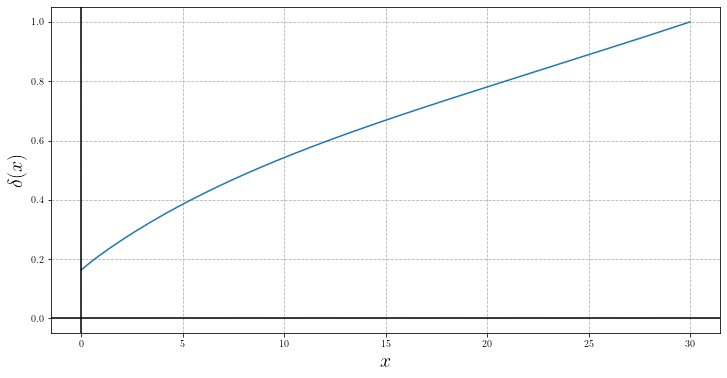

In [7]:
x = np.linspace(0,end,n+1)
plt.figure(figsize=(12,6))
plt.plot(x, delta)
plt.xlabel('$x$', fontsize=20)
plt.ylabel(r'$\delta(x)$', fontsize=20)
plt.axhline(y=0, color='k');plt.axvline(x=0, color='k')
plt.grid( color='0.7', linestyle='--')

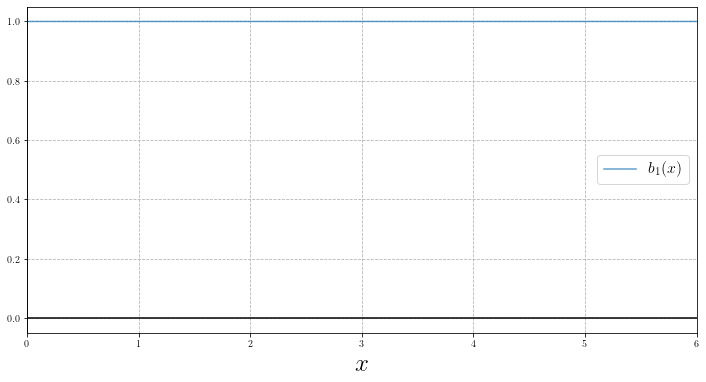

In [8]:
B1 = np.maximum(0,B1)
B2 = np.maximum(0,B2)

m = n
up = round(B1[n-1],1)
x = np.arange(m)*DELTA
plt.figure(figsize=(12,6))
plt.plot(x,B1[0:m],label='$b_1(x)$',alpha=0.7)
#plt.plot(x,B2[0:m],label='$b_2(x)$',alpha=0.7)
plt.xlabel('$x$', fontsize=25)
plt.xlim((0,6))
plt.axhline(y=0, color='k');plt.axvline(x=0, color='k')
#plt.yticks([0,up,2*up,4*up],[0,up,2*up,r'$\infty$'],fontsize=16)
plt.grid( color='0.7', linestyle='--')
plt.legend(fontsize=16)
plt.show()

In [9]:
IndMin = np.argmin(deltahat)

In [10]:
deltahat[IndMin]

0.02162161842872482

In [11]:
IndMin*DELTA

22.41

In [12]:
x = np.linspace(0,end,n+1)
v = delta
vhat = deltahat
V = v/vhat[IndMin]
Vp = vhat/vhat[IndMin]

V[IndMin+1:] = V[IndMin] + np.arange(IndMin+1, n+1)*DELTA - (IndMin)*DELTA
Vp[IndMin+1:] = 1.0

In [13]:
V_pcommon = V-x

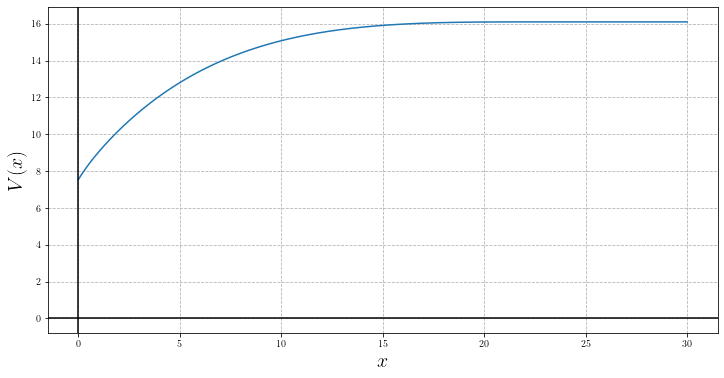

In [14]:
x = np.linspace(0,end,n+1)
plt.figure(figsize=(12,6))
plt.plot(x, V_pcommon)
plt.xlabel('$x$', fontsize=20)
plt.ylabel(r'$V(x)$', fontsize=20)
#plt.xlim(0,17.5)
plt.axhline(y=0, color='k');plt.axvline(x=0, color='k')
plt.grid( color='0.7', linestyle='--')
plt.show()

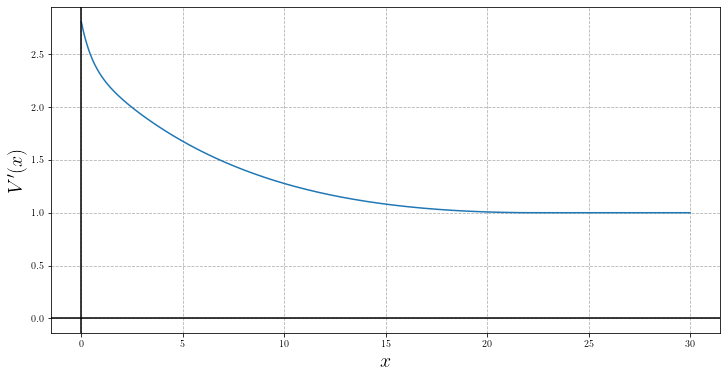

In [15]:
x = np.linspace(0,end,n)
plt.figure(figsize=(12,6))
plt.plot(x, Vp)
plt.xlabel('$x$', fontsize=20)
plt.ylabel(r"$V'(x)$", fontsize=20)
plt.axhline(y=0, color='k');plt.axvline(x=0, color='k')
plt.grid( color='0.7', linestyle='--')
plt.show()

In [16]:
import pandas as pd
IND = np.arange(0,n)
x = np.linspace(0,end,n+1)
DF = pd.DataFrame([x[IND],V_pcommon[IND],B1[IND],B2[IND]],
                  index=['x','V','Line1','Line2']).T
DF.to_csv('onePcommon_30_0.005.csv')

In [167]:
supL = np.array(n*[0.0])
B1 = np.array(n*[0.0])
B2 = np.array(n*[0.0])
B3 = np.array(n*[0.0])

for i in range(n):
    def nL(a):
        j = np.arange(i+1)
        pRR = pR(a[0],a[1])
        if pRR>0: return -(pRR*Vp[i]-(c+beta)*V[i] + beta*np.sum(V[i-j]*DGR(a[0],a[1],j)))
        else : return  np.inf
    MIN = differential_evolution(nL, [(0.0001, 1.0), (0.0001, 1.0)])#,popsize=30, strategy='rand1exp')
    supL[i] = -MIN.fun
    #d[i+1]=d[i]+DELTA*dhat[i]

    B1[i] = MIN.x[0]
    B2[i] = MIN.x[1]
    #B3[i] = MIN.x[2]
    if i%(n//20)==0: 
        print(str(round(100*i/n))+'%', end=', ')
        print('d('+str(round(i*DELTA,2))+') = '+str(supL[i]))
print('100%')

0%, d(0.0) = -8.881784197001252e-16
5%, d(0.5) = 1.7763568394002505e-15
10%, d(1.0) = 3.552713678800501e-15
15%, d(1.5) = 7.105427357601002e-15
20%, d(2.0) = 7.105427357601002e-15
25%, d(2.5) = -0.013434238445213964
30%, d(3.0) = -0.10076479505692149
35%, d(3.5) = -0.22657627881026343
40%, d(4.0) = -0.36742485464110786
45%, d(4.5) = -0.5140017894141735
50%, d(5.0) = -0.6627299196394745
55%, d(5.5) = -0.8122592146954162
60%, d(6.0) = -0.9620854249827957
65%, d(6.5) = -1.1120213514087212
70%, d(7.0) = -1.2619977488395904
75%, d(7.5) = -1.4119890589738304
80%, d(8.0) = -1.5619858605966073
85%, d(8.5) = -1.7119846836325507
90%, d(9.0) = -1.8619842505743094
95%, d(9.5) = -2.0119840912438036
100%


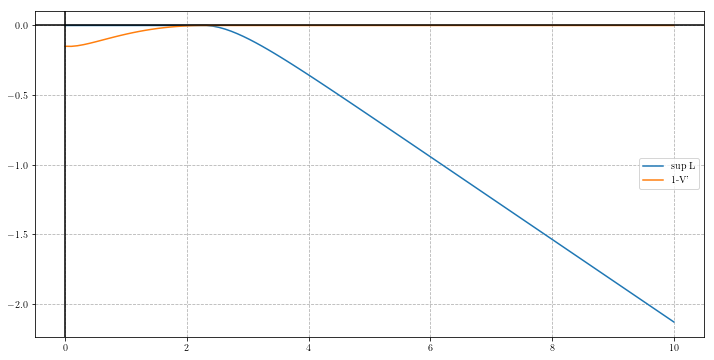

In [168]:
x = np.linspace(0,end,n)
plt.figure(figsize=(12,6))
plt.plot(x, supL, label = r"sup L")
plt.plot(x, 1-Vp, label = r"1-V'")
plt.axhline(y=0, color='k');plt.axvline(x=0, color='k')
plt.grid( color='0.7', linestyle='--')
plt.legend()
plt.show()

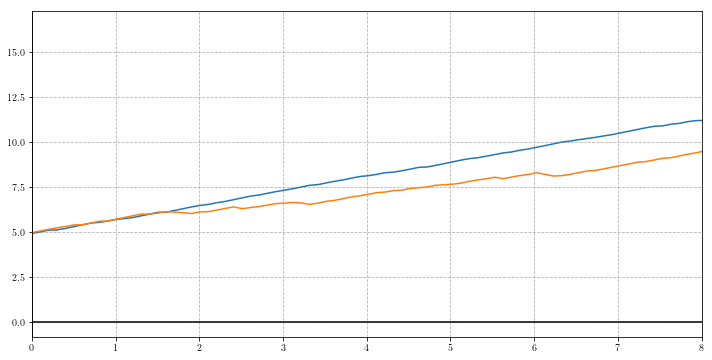

In [48]:
x = np.linspace(0,end,n)
plt.figure(figsize=(12,6))
plt.plot(x, B1)
plt.plot(x, B2)
#plt.plot(x, B3)
plt.xlim(0,8)
plt.axhline(y=0, color='k');plt.axvline(x=0, color='k')
plt.grid( color='0.7', linestyle='--')
plt.show()